### Imports and loading data

In [5]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [11]:
dataset_3 = pd.read_csv("dataset_3.csv")


------------------------------------- NEW FILE --------------------------

# Import CSV

In [9]:
#data = pd.read_csv("../raw_data/clean_dataset_1.csv", index_col=0)
data = dataset_3b
data.rename(columns={'Review': 'reviews', 'Rating': 'review_score'}, inplace=True)

# Remove less than 5 words

In [13]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [14]:
data['length'] = data['reviews'].apply(lambda x: len(word_tokenize(str(x))))
data.drop(data[data['length'] < 6].index, inplace=True)
data.drop(columns=['length'], inplace=True)
data.reset_index(drop=True, inplace=True)
data

,reviews,review_score
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


#  NEURAL NETWORK

In [88]:
df_1 = data[data['review_score'] < 3][:3000]

In [24]:
# df_2 = data[(data['review_score'] > 5) & (data['review_score'] <8)][:5000]

In [25]:
# df_3 = data[(data['review_score'] > 8) & (data['review_score'] <4)][:2000]

In [87]:
df_4 = data[(data['review_score'] > 4) & (data['review_score'] < 10.1)][:3000]

In [72]:
pd.concat([df_1,df_4])

,reviews,review_score
1,ok nothing special charge diamond member hilto...,2
10,"poor value stayed monaco seattle july, nice ho...",2
15,horrible customer service hotel stay february ...,1
16,disappointed say anticipating stay hotel monac...,2
24,great location need internally upgrade advanta...,2
...,...,...
7234,lovely hotel left bank hotel des grands hommes...,5
7236,family france traveled paris husband 3 childre...,5
7238,"ca n't wait come, n't pleased stay grande homm...",5
7239,great hotel great view wife just returned 7 ni...,5


In [73]:
X_2 = pd.concat([df_1,df_4])['reviews']
y_2 = pd.concat([df_1,df_4])['review_score']
y = pd.concat([df_1,df_4])['review_score']
print(X_2.shape, y_2.shape)
X_2.reset_index(drop=True, inplace=True)

(6000,) (6000,)


In [75]:
# Baseline Model
from sklearn.metrics import mean_absolute_error

y_pred_baseline = np.random.uniform(low=0, high=5., size=(1200,))  # only 20%

baseline_mae = mean_absolute_error(y[:1200], y_pred_baseline)
baseline_mae

1.5342161553587934

In [76]:
# Tokenize 
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 5000

def tokenInit(train, max_words):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train)
    return tokenizer

In [77]:
tokenizer = tokenInit(X_2, max_words)

In [78]:
# Check the top Words
# tokenizer.word_index

In [79]:
sequences = tokenizer.texts_to_sequences(X_2)
# sequences[0]

In [80]:
# We need Padding
len(sequences[0]),len(sequences[1]),len(sequences[2]),len(sequences[3]),len(sequences[4])

(248, 45, 212, 231, 33)

In [81]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_pad = pad_sequences(sequences, dtype='int32', padding='post') 

In [82]:
X_pad.shape

(6000, 1489)

 ### Hold out

In [83]:
from sklearn.model_selection import train_test_split

# Hold out 
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2)

#check
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4800, 1489), (1200, 1489), (4800,), (1200,))

 ### NN

In [84]:
from sklearn.model_selection import cross_validate
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers


def initialize_model():
    ### Model architecture
    model_gensim_2 = models.Sequential()
 
    ### Embedding Padded
    model_gensim_2.add(layers.Embedding(input_dim=5000, output_dim=100, mask_zero=True))
        
    ### First convolution & max-pooling
    model_gensim_2.add(layers.LSTM(units=100, activation='tanh', return_sequences=True)) #, recurrent_dropout=0.3))   #244 or 100 ??
    model_gensim_2.add(layers.LSTM(units=100, activation='tanh', return_sequences=True))
    model_gensim_2.add(layers.LSTM(units=50, activation='tanh')) #, recurrent_dropout=0.3))   #244 or 100 ??
    model_gensim_2.add(layers.Dropout(0.5))                     #change params
    model_gensim_2.add(layers.Dense(40, activation='relu', kernel_regularizer=regularizers.L1(0.01)))    #Use regulazers
    model_gensim_2.add(layers.Dropout(0.3))                     #change params
    model_gensim_2.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.L1(0.01)))    #Use regulazers
    model_gensim_2.add(layers.Dropout(0.2))                     #change params
    model_gensim_2.add(layers.Dense(10, activation='relu', kernel_regularizer=regularizers.L1(0.01)))    #Use regulazers
    model_gensim_2.add(layers.Dropout(0.2))                     #change params 

    ### Last layer (let's say a classification with 10 output)
    model_gensim_2.add(layers.Dense(1, activation='linear'))
        
    ### Model compilation
    model_gensim_2.compile(loss='mse', 
                  optimizer='rmsprop',    #rmsprop or adam?
                  metrics=['mae'])     

    return model_gensim_2

In [85]:
model_gensim_2 = initialize_model()
model_gensim_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 100)         80400     
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 100)         80400     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 40)                2040      
_________________________________________________________________
dropout_17 (Dropout)         (None, 40)               

In [86]:
### YOUR CODE HERE

from tensorflow.keras.callbacks import EarlyStopping 

# YOUR CODE HERE
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
model_gensim_2 = initialize_model()

history = model_gensim_2.fit(X_train, y_train,
          validation_split=0.2,
          batch_size=32,
          epochs=200,
          verbose=1,
          callbacks=[es])

Epoch 1/200
120/120 [==============================] - 19s 100ms/step - loss: 10.7487 - mae: 2.1824 - val_loss: 7.0189 - val_mae: 1.7709
Epoch 2/200
120/120 [==============================] - 9s 77ms/step - loss: 7.5764 - mae: 1.8499 - val_loss: 5.8161 - val_mae: 1.7527
Epoch 3/200
120/120 [==============================] - 9s 79ms/step - loss: 5.6809 - mae: 1.5611 - val_loss: 3.3819 - val_mae: 1.0074
Epoch 4/200
120/120 [==============================] - 9s 76ms/step - loss: 3.5202 - mae: 1.0198 - val_loss: 2.5545 - val_mae: 0.9275
Epoch 5/200
120/120 [==============================] - 9s 77ms/step - loss: 2.9474 - mae: 0.9628 - val_loss: 2.0398 - val_mae: 0.7385
Epoch 6/200
120/120 [==============================] - 9s 75ms/step - loss: 2.5294 - mae: 0.8975 - val_loss: 1.6375 - val_mae: 0.5214
Epoch 7/200
120/120 [==============================] - 9s 78ms/step - loss: 2.1415 - mae: 0.8298 - val_loss: 1.5431 - val_mae: 0.6509
Epoch 8/200
120/120 [==============================] - 9s 7

In [587]:
# history.history

In [89]:
model_gensim_2.evaluate(X_test, y_test, verbose=0)

[0.8868385553359985, 0.4604249596595764]

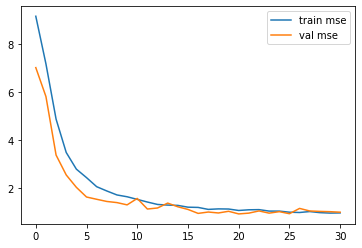

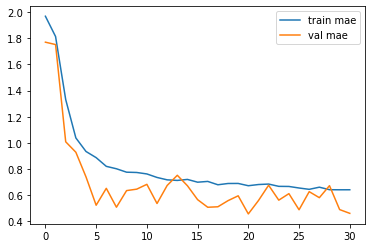

In [90]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train mse')      #CHANGE
plt.plot(history.history['val_loss'], label='val mse')      #CHANGE
plt.legend()
plt.show()
plt.plot(history.history['mae'], label='train mae')      #CHANGE
plt.plot(history.history['val_mae'], label='val mae')
plt.legend()
plt.show()

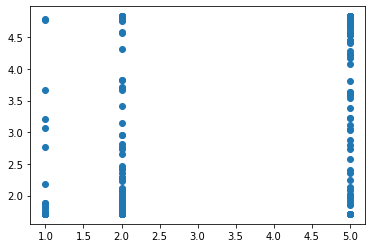

In [91]:
import matplotlib.pyplot as plt 
y_pred_model = model_gensim_2.predict(X_test)
plt.scatter(y_test, y_pred_model)

Baseline Model MAE 1.5342161553587934


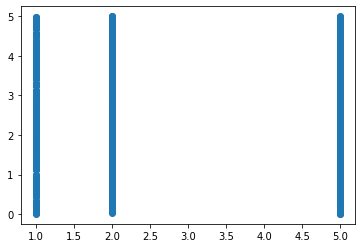

In [92]:
# Baseline Model
print(f'Baseline Model MAE {baseline_mae}')
plt.scatter(y_test, y_pred_baseline)

In [93]:
# 0	angry made post available via possible site us...	2.9

# pre process and convert to pad ...
X_2[0] # = sequences[0]

'ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman bu

In [94]:
X_pad[0] # sequences[0]
# sequences[0]

array([145, 110, 296, ...,   0,   0,   0], dtype=int32)

In [95]:
tokenizer.word_index["broken"],   tokenizer.word_index["angry"],   # Val?/

(464, 2455)

In [96]:
#model_gensim.predict([[X_pad[0]]])
model_gensim_2.predict(np.expand_dims(X_pad[0], axis=0))[0][0]

1.7097647

In [97]:
sentence_test = "I really liked the hotel. Everything was amazing, thanks for all"

sentence_test =  tokenizer.texts_to_sequences([sentence_test])
sentence_test = pad_sequences(sentence_test, dtype='int32', padding='post', maxlen=X_pad[0].shape[0])
sentence_test

model_gensim_2.predict(np.expand_dims(sentence_test[0], axis=0))[0][0]

4.692631

In [98]:
sentence_test = "The hotel was horrible. We had prostitutes, drug addicts, fights and blood all over the bed. Everything was broken and smelly"

sentence_test =  tokenizer.texts_to_sequences([sentence_test])
sentence_test = pad_sequences(sentence_test, dtype='int32', padding='post', maxlen=X_pad[0].shape[0])
sentence_test

model_gensim_2.predict(np.expand_dims(sentence_test[0], axis=0))[0][0]

1.7097647

In [99]:
sentence_test = "Great vacation until we tried to travel home. We tried calling and waited more than 2 hours for a callback and then they were unable/unwilling to help us. Stranded for 48 hours because of this company with no help rebooking flights. We are out for hotel, food, and time off work because I was hung up on repeatedly by their customer service department. Once I was finally home, they told me there's nothing they can do for me that they were really sorry all this happened. They were unwilling to make it right, but told me that I could have requested a refund for my flight home if I would have been able to reach them at the time."

sentence_test =  tokenizer.texts_to_sequences([sentence_test])
sentence_test = pad_sequences(sentence_test, dtype='int32', padding='post', maxlen=X_pad[0].shape[0])
sentence_test

model_gensim_2.predict(np.expand_dims(sentence_test[0], axis=0))[0][0]

1.7097647

In [100]:
sentence_test = "The hotel itself was great, affordable and clean. The bar in the lobby was inviting and the breakfast was great. The hotel was located close to a public transportation site, which made arrival and departure very easy."

sentence_test =  tokenizer.texts_to_sequences([sentence_test])
sentence_test = pad_sequences(sentence_test, dtype='int32', padding='post', maxlen=X_pad[0].shape[0])
sentence_test

model_gensim_2.predict(np.expand_dims(sentence_test[0], axis=0))[0][0]

4.827971

# Export

In [ ]:
# import pickle

# # Export pipeline as pickle file
# with open("pipeline.pkl", "wb") as file:
#     pickle.dump(best_pipeline, file)